PPP (with DnCNN) Image Superresolution
======================================

This example demonstrates the use of the ADMM Plug and Play Priors
(PPP) algorithm <cite data-cite="venkatakrishnan-2013-plugandplay2"/>, with DnCNN
<cite data-cite="zhang-2017-dncnn"/> denoiser, for solving a simple image
superresolution problem.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico

import scico
import scico.numpy as snp
import scico.random
from scico import denoiser, functional, linop, loss, metric, plot
from scico.data import kodim23
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.solver import cg
from scico.util import device_info
plot.config_notebook_plotting()

Define downsampling function.

In [2]:
def downsample_image(img, rate):
    img = snp.mean(snp.reshape(img, (-1, rate, img.shape[1], img.shape[2])), axis=1)
    img = snp.mean(snp.reshape(img, (img.shape[0], -1, rate, img.shape[2])), axis=2)
    return img

Read a ground truth image.

In [3]:
img = snp.array(kodim23(asfloat=True)[160:416, 60:316])

Create a test image by downsampling and adding Gaussian white noise.

In [4]:
rate = 4  # downsampling rate
σ = 2e-2  # noise standard deviation

Afn = lambda x: downsample_image(x, rate=rate)
s = Afn(img)
input_shape = img.shape
output_shape = s.shape
noise, key = scico.random.randn(s.shape, seed=0)
sn = s + σ * noise

Set up the PPP problem pseudo-functional. The DnCNN denoiser
<cite data-cite="zhang-2017-dncnn"/> is used as a regularizer.

In [5]:
A = linop.LinearOperator(input_shape=input_shape, output_shape=output_shape, eval_fn=Afn)
f = loss.SquaredL2Loss(y=sn, A=A)
C = linop.Identity(input_shape=input_shape)
g = functional.DnCNN("17M")

Compute a baseline solution via denoising of the pseudo-inverse of the
forward operator. This baseline solution is also used to initialize the
PPP solver.

In [6]:
xpinv, info = cg(A.T @ A, A.T @ sn, snp.zeros(input_shape))
dncnn = denoiser.DnCNN("17M")
xden = dncnn(xpinv)

Set up an ADMM solver and solve.

In [7]:
ρ = 3.4e-2  # ADMM penalty parameter
maxiter = 12  # number of ADMM iterations
solver = ADMM(
    f=f,
    g_list=[g],
    C_list=[C],
    rho_list=[ρ],
    x0=xden,
    maxiter=maxiter,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": 1e-3, "maxiter": 10}),
    itstat_options={"display": True},
)

print(f"Solving on {device_info()}\n")
xppp = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)



Iter  Time      Prml Rsdl  Dual Rsdl  CG It  CG Res   
------------------------------------------------------
   0  3.98e-01  8.395e+00  4.096e+00      1  2.533e-08


   1  7.23e-01  4.061e+00  4.306e+00      2  1.050e-09


   2  9.69e-01  2.255e+00  3.050e+00      2  4.235e-10


   3  1.22e+00  1.482e+00  2.197e+00      2  4.983e-10


   4  1.46e+00  1.005e+00  1.717e+00      2  2.744e-10


   5  1.70e+00  7.124e-01  1.410e+00      2  1.766e-10


   6  1.95e+00  5.292e-01  1.182e+00      2  1.319e-10


   7  2.25e+00  2.610e-01  7.981e-01      1  9.034e-04


   8  2.50e+00  4.601e-01  7.899e-01      1  6.438e-04


   9  2.74e+00  1.612e-01  4.840e-01      1  8.023e-04


  10  2.99e+00  3.113e-01  5.826e-01      1  6.652e-04


  11  3.23e+00  1.674e-01  3.965e-01      1  6.904e-04


Plot convergence statistics.

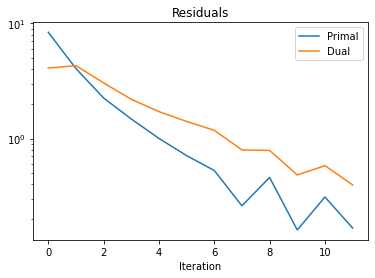

In [8]:
plot.plot(
    snp.vstack((hist.Prml_Rsdl, hist.Dual_Rsdl)).T,
    ptyp="semilogy",
    title="Residuals",
    xlbl="Iteration",
    lgnd=("Primal", "Dual"),
)

Show reference and test images.

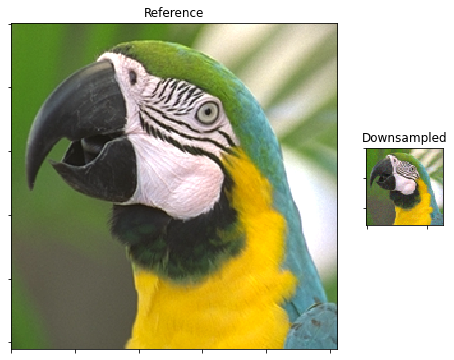

In [9]:
fig = plot.figure(figsize=(8, 6))
ax0 = plot.plt.subplot2grid((1, rate + 1), (0, 0), colspan=rate)
plot.imview(img, title="Reference", fig=fig, ax=ax0)
ax1 = plot.plt.subplot2grid((1, rate + 1), (0, rate))
plot.imview(sn, title="Downsampled", fig=fig, ax=ax1)
fig.show()

Show recovered full-resolution images.

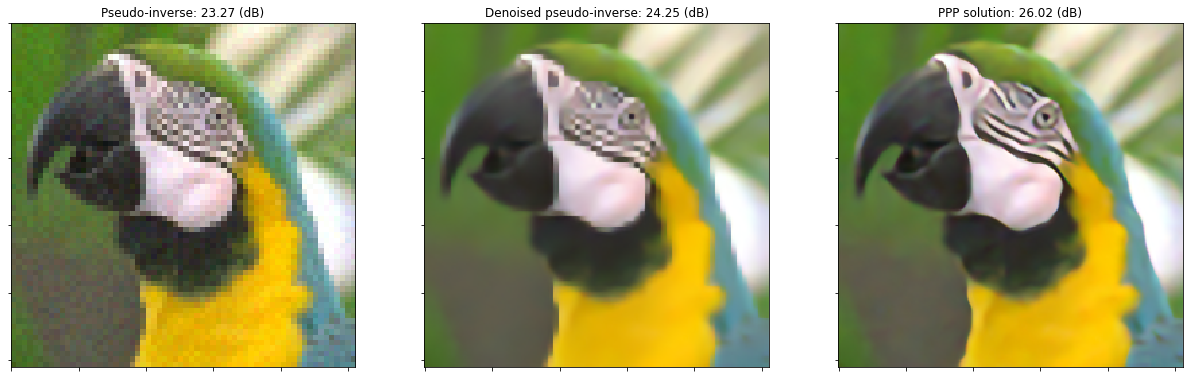

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(21, 7))
plot.imview(xpinv, title="Pseudo-inverse: %.2f (dB)" % metric.psnr(img, xpinv), fig=fig, ax=ax[0])
plot.imview(
    xden, title="Denoised pseudo-inverse: %.2f (dB)" % metric.psnr(img, xden), fig=fig, ax=ax[1]
)
plot.imview(xppp, title="PPP solution: %.2f (dB)" % metric.psnr(img, xppp), fig=fig, ax=ax[2])
fig.show()